In [1]:
%matplotlib inline

# PR02: Linear discriminants - part 1

In [2]:
import numpy as np
from sklearn import datasets
from sklearn import metrics

from matplotlib import pylab as plt

## Generate a binary classification problem

In [13]:
X0, y0 = datasets.make_classification(1000, n_features=2, weights=[0.4,0.6],
                                    n_informative=2, n_redundant=0, 
                                    n_clusters_per_class=1, flip_y=0.01,
                                    shuffle=True)
y0[y0 == 0] = -1

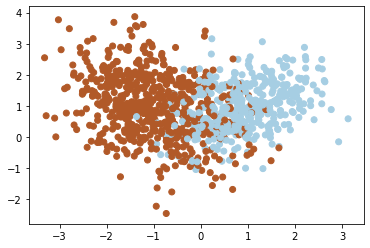

In [14]:
# plot the data points - just to see how the classes look like
plt.scatter(X0[:,0], X0[:,1], c=y0, cmap=plt.cm.Paired)

## Perceptron

First, try your own implementation of the Perceptron algorithm. For example, fill in the gaps below:

In [15]:
# naive implementation of a Perceptron

# train a perceptron
def perc(X, y, theta=0.5, eta=0.1):
    n, d = X.shape    # n samples, d variables
    a = np.ones(d+1)  # a = [1,....,1]
    Z = np.zeros((n, d+1))
    
    for i in np.arange(n):
        Z[i, 0] =  y[i]
        Z[i, 1:(d+1)] = y[i] * X[i,:]

    k = 0
    grad = 2*theta
    while np.abs(grad) > theta:
        grad_v = np.zeros(d+1)
        for i in np.arange(n):
            if np.dot(a, Z[i,:]) < 0:
                # i-th sample is misclassified
                a += eta*Z[i,:]
                k += 1
                grad_v += Z[i,:]
                print("Coefficient update {:d}".format(k))
        grad = eta * np.linalg.norm(grad_v) # norm
    
    return a


    
    return a


# use a trained model to classify a new dataset
def perc_clsf(X, a):
    d = a[0]
    d += np.dot(X, a[1:])
    c = np.ones(X.shape[0], dtype=np.int)
    c[d < 0] = -1

    return c


# show separation boundary
def plot_clsf_reg(X, y, a):
    xmn, xmx = X[:,0].min() - 1, X[:,0].max() + 1
    ymn, ymx = X[:,1].min() - 1, X[:,1].max() + 1
    
    xx, yy = np.meshgrid(np.arange(xmn,xmx,0.02), np.arange(ymn,ymx,0.02))
    Z = perc_clsf(np.c_[xx.ravel(),yy.ravel()], a)

    # for plotting, convert to 0, 1:
    Z = (Z + 1) / 2
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

    # add the points with 
    plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.show()


And apply it to the data generated above or to the classical IRIS dataset:

Coefficient update 1
Coefficient update 2
Coefficient update 3
Coefficient update 4
Coefficient update 5
Error rate: 0.333333


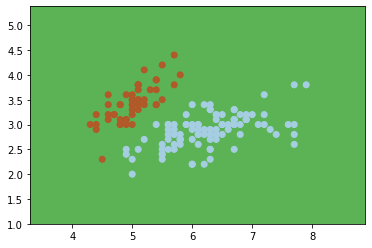

[ 0.7  -0.92  0.16]


In [17]:
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris.target
# Just 2 classes...
y[y > 0] = -1
y[y == 0] = 1

a = perc(X, y)
yy = perc_clsf(X, a)  # get the predicted labels...
# ...and compare y to yy (error rate):
print("Error rate: {:f}".format(np.sum(y != yy) / float(yy.size)))

# TODO: try
#a = perc(X, y, 0.1)
#a = perc(X, y, 0.05)

plot_clsf_reg (X, y, a)
print(a)

And the professional way:

In [19]:
from sklearn.linear_model import Perceptron

Have a look at [http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html] for documentation of the class. Identify the parameters discussed during the lecture.

Error rate: 0.163000
[[-3.86378782 -0.48746302]]
[-1.]


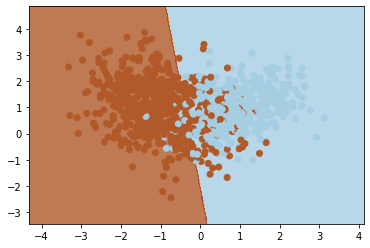

In [20]:
clsf = Perceptron()   # create a default Perceptron classifier. TODO: try different initial parameters
clsf.fit(X0, y0)      # train the classifier
yy = clsf.predict(X0) # make predictions. NOTE: usually you predict a new set of points
print("Error rate: {:f}".format(np.sum(y0 != yy) / float(yy.size)))
print(clsf.coef_)
print(clsf.intercept_)
w = np.hstack((clsf.intercept_, clsf.coef_[0,] ))

plot_clsf_reg (X0, y0, w)

### TODO/HOMEWORK
- use numpy.random.shuffle() function, to shuffle your dataset and then re-train the classifier. Does the solution change?
- random partition your data into a "train set" and a "test set" (e.g. using numpy.random.choice()). Then train a classifier on the "train set" and apply it to the "test set". How does the test error rate compare with the train error rate?

## Fisher linear discriminant
- FDA (Fisher discriminant analysis) is LDA (linear discriminant analysis) for 2 classes
- check the documentation for LDA: http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
- repeat the training/testing/plotting steps from above, but in the case of LDA. 
- go through the example below (taken from scikit-learn http://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html) and try to understand the principles (not the details):

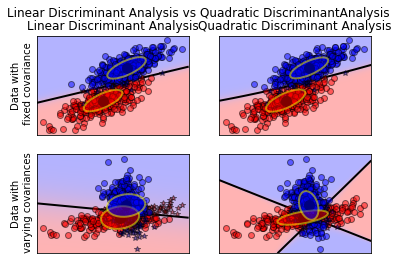

In [22]:
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# #############################################################################
# Colormap
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)


# #############################################################################
# Generate datasets
def dataset_fixed_cov():
    '''Generate 2 Gaussians samples with the same covariance matrix'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -0.23], [0.83, .23]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


def dataset_cov():
    '''Generate 2 Gaussians samples with different covariance matrices'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -1.], [2.5, .7]]) * 2.
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


# #############################################################################
# Plot functions
def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title('Linear Discriminant Analysis')
        plt.ylabel('Data with\n fixed covariance')
    elif fig_index == 2:
        plt.title('Quadratic Discriminant Analysis')
    elif fig_index == 3:
        plt.ylabel('Data with\n varying covariances')

    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    alpha = 0.5

    # class 0: dots
    plt.plot(X0_tp[:, 0], X0_tp[:, 1], 'o', alpha=alpha,
             color='red', markeredgecolor='k')
    plt.plot(X0_fp[:, 0], X0_fp[:, 1], '*', alpha=alpha,
             color='#990000', markeredgecolor='k')  # dark red

    # class 1: dots
    plt.plot(X1_tp[:, 0], X1_tp[:, 1], 'o', alpha=alpha,
             color='blue', markeredgecolor='k')
    plt.plot(X1_fp[:, 0], X1_fp[:, 1], '*', alpha=alpha,
             color='#000099', markeredgecolor='k')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.))
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='k')

    # means
    plt.plot(lda.means_[0][0], lda.means_[0][1],
             'o', color='black', markersize=10, markeredgecolor='k')
    plt.plot(lda.means_[1][0], lda.means_[1][1],
             'o', color='black', markersize=10, markeredgecolor='k')

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='yellow',
                              linewidth=2, zorder=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariance_[0], 'red')
    plot_ellipse(splot, qda.means_[1], qda.covariance_[1], 'blue')

for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)
    plot_lda_cov(lda, splot)
    plt.axis('tight')

    # Quadratic Discriminant Analysis
    qda = QuadraticDiscriminantAnalysis(store_covariance=True)
    y_pred = qda.fit(X, y).predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2 * i + 2)
    plot_qda_cov(qda, splot)
    plt.axis('tight')
plt.suptitle('Linear Discriminant Analysis vs Quadratic Discriminant'
             'Analysis')
plt.show()